In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import chi2_contingency, ks_2samp, chisquare, poisson

In [20]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [21]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
DRIVER_GENES = "../data/driver_genes"

CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types that have driver gene data
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [22]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [23]:
# genome-wide mutations
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
genome_wide_mutations["tissue_type"] = genome_wide_mutations["cancer_type"].apply(lambda x: x.split("-")[0])
genome_wide_mutations.head()

,Tumor_Sample_Barcode,total_mutations,num_drivers,cancer_type,cna_burden,tissue_type
0,00493087-9d9d-40ca-86d5-936f1b951c93,2778,5,CNS-Oligo,17.324180,CNS
1,2aeaab9f-4459-4be8-91e7-e0746cbd671c,3388,4,CNS-Oligo,19.993935,CNS
2,3a81f733-b3a3-4578-b925-a663612bc92c,2489,2,CNS-Oligo,17.647446,CNS
3,3d477ac1-3bdf-4410-9594-1a3a1412c6ae,5801,3,CNS-Oligo,24.948595,CNS
4,4853fd17-7214-4f0c-984b-1be0346ca4ab,2004,2,CNS-Oligo,9.704638,CNS


In [24]:
# get all mutations in driver genes
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
	df["cancer_type"] = cancer_type
	driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	df = df[df["gene"].isin(driver_genes_list)]
	df = pd.merge(df, driver_genes[["gene", "gene_length"]], on="gene", how="left")
	mut_df = pd.concat([mut_df, df])
mut_df.head()

,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,cancer_type,gene_length
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869:C:G,True,"mutational, CNA",True,exonic,6.224800,33.0,CNS-Oligo,35055
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826:T:C,True,"mutational, CNA",True,exonic,5.575207,29.7,CNS-Oligo,27261
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878:T:G,True,"mutational, CNA",True,exonic,4.657281,25.4,CNS-Oligo,27261
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,exonic,3.897263,23.4,CNS-Oligo,29848
4,TP53,+,Nonsense_Mutation,2aeaab9f-4459-4be8-91e7-e0746cbd671c,DO22285,17:7574012-7574012:C:A,17:7574012:C:A,True,"mutational, CNA",True,exonic,8.096992,36.0,CNS-Oligo,25760


In [25]:
test = mut_df[["driver", "gene", "genic_region"]]
test

,driver,gene,genic_region
0,True,FUBP1,exonic
1,True,CIC,exonic
2,True,CIC,exonic
3,True,IDH1,exonic
4,True,TP53,exonic
...,...,...,...
3544,False,CSMD3,intronic
3545,False,CSMD3,intronic
3546,False,CSMD3,intronic
3547,False,CSMD3,intronic


In [26]:
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

(90258, 15)
(82512, 15)


In [27]:
# passenger density for each gene in each sample
passenger_density = mut_df.groupby(["Tumor_Sample_Barcode", "gene"]).agg({
    "cancer_type": "first",
    "has_driver": "first",
    "driver": lambda x: x.value_counts().get(False, 0),
    "gene_length": "first"
}).reset_index()
passenger_density = passenger_density.rename(columns={"driver": "passenger_count"})
# adjust for genome-wide mutation rate, cna burden and gene length
print(passenger_density.shape, genome_wide_mutations.shape)
passenger_density = pd.merge(passenger_density, genome_wide_mutations, on=["cancer_type", "Tumor_Sample_Barcode"], how="left")
passenger_density["cna_burden"] = passenger_density["cna_burden"] / 100 # convert from percentage to fraction
print(passenger_density.shape)
# mutation rate = total mutations / genome size
# expected rate in gene = mutation rate * gene length
# adjusted mut (adjusting for genome-wide mutation rate) = mut / expected rate in gene = total mutations * genome size / (total mutations * gene length)
# adjusted mut (adjusting for cna burden) = adjusted mut / cna_burden = total mutations * genome size / (total mutations * gene length * cna_burden)
passenger_density["adj_passenger_density"] = passenger_density["passenger_count"] * 3.2e9 / (passenger_density["total_mutations"] * passenger_density["gene_length"] * passenger_density["cna_burden"])
passenger_density["organ"] = passenger_density["cancer_type"].apply(lambda x: x.split("-")[0])
passenger_density = passenger_density[["organ", "cancer_type", "Tumor_Sample_Barcode", "gene", "has_driver", "passenger_count", "adj_passenger_density", "total_mutations", "cna_burden", "gene_length"]]
passenger_density.head()

(9713, 6) (2778, 6)
(9713, 10)


,organ,cancer_type,Tumor_Sample_Barcode,gene,has_driver,passenger_count,adj_passenger_density,total_mutations,cna_burden,gene_length
0,Ovary,Ovary-AdenoCA,0009b464-b376-4fbc-8a56-da538269a02f,CDK12,True,0,0.000000,16168,0.905215,103397
1,Ovary,Ovary-AdenoCA,0009b464-b376-4fbc-8a56-da538269a02f,PTPRT,False,12,2.348470,16168,0.905215,1117219
2,Ovary,Ovary-AdenoCA,0009b464-b376-4fbc-8a56-da538269a02f,TP53,True,0,0.000000,16168,0.905215,25760
3,Liver,Liver-HCC,0040b1b6-b07a-4b6e-90ef-133523eaf412,APC,False,1,2.611627,15823,0.558139,138742
4,Liver,Liver-HCC,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID1A,False,1,4.209759,15823,0.558139,86072


In [28]:
# add rows for samples with no mutations in driver genes
tumors = passenger_density["Tumor_Sample_Barcode"].unique()
for tumor in tumors:
	cancer_type = passenger_density[passenger_density["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	for gene in driver_genes_list:
		if len(passenger_density[(passenger_density["Tumor_Sample_Barcode"] == tumor) & (passenger_density["gene"] == gene)]) == 0:
			passenger_density = pd.concat([passenger_density, pd.DataFrame({
				"cancer_type": [cancer_type],
				"Tumor_Sample_Barcode": [tumor], 
				"gene": [gene], 
				"has_driver": [False], 
				"adj_passenger_density": [0],
				"passenger_count": [0],
				"total_mutations": [0],
				"cna_burden": [0],
				"gene_length": [driver_genes[driver_genes["gene"] == gene]["gene_length"].values[0]],
			})])
passenger_density["organ"] = passenger_density["cancer_type"].apply(lambda x: x.split("-")[0])
print(passenger_density.shape)
passenger_density.head()

(24625, 10)


,organ,cancer_type,Tumor_Sample_Barcode,gene,has_driver,passenger_count,adj_passenger_density,total_mutations,cna_burden,gene_length
0,Ovary,Ovary-AdenoCA,0009b464-b376-4fbc-8a56-da538269a02f,CDK12,True,0,0.000000,16168,0.905215,103397
1,Ovary,Ovary-AdenoCA,0009b464-b376-4fbc-8a56-da538269a02f,PTPRT,False,12,2.348470,16168,0.905215,1117219
2,Ovary,Ovary-AdenoCA,0009b464-b376-4fbc-8a56-da538269a02f,TP53,True,0,0.000000,16168,0.905215,25760
3,Liver,Liver-HCC,0040b1b6-b07a-4b6e-90ef-133523eaf412,APC,False,1,2.611627,15823,0.558139,138742
4,Liver,Liver-HCC,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID1A,False,1,4.209759,15823,0.558139,86072


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test smaller, P_val:2.165e-44 U_stat=2.901e+07


Text(16.47222222222222, 0.5, 'Adjusted passenger density ($\\log_{10}$)')

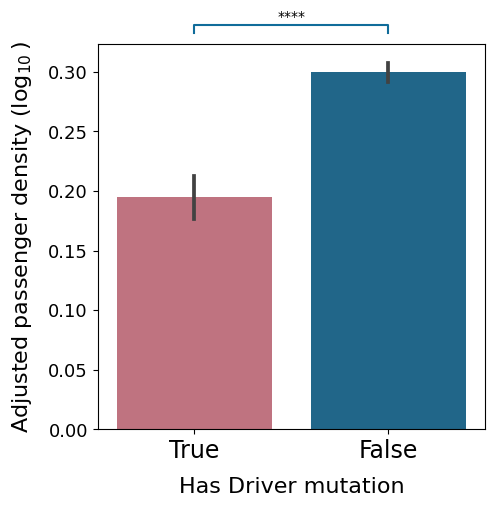

In [29]:
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))

plt.figure(figsize=(5, 5))
ax = sns.barplot(
    x="has_driver",
    y="passenger_density_log",
    data=passenger_density,
    order=[True, False],
    palette=cmap
)
# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=passenger_density, 
    x="has_driver",
    y="passenger_density_log", 
    pairs=[(True, False)],
    order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

plt.xlabel("Has Driver mutation", fontsize=16, labelpad=10)
plt.xticks(fontsize=17)
plt.yticks(fontsize=13)
plt.ylabel(r"Adjusted passenger density ($\log_{10}$)", fontsize=16, labelpad=10)

## Passenger density by cancer and tissue type

In [30]:
passenger_density_by_tissue = passenger_density.groupby(["organ", "has_driver"]).agg({
	"adj_passenger_density": "mean",
}).reset_index()
passenger_density_by_tissue = passenger_density_by_tissue.pivot(index="organ", columns="has_driver", values="adj_passenger_density")
passenger_density_by_tissue["diff"] = passenger_density_by_tissue[False] - passenger_density_by_tissue[True]
passenger_density_by_tissue["ratio"] = passenger_density_by_tissue[False] / passenger_density_by_tissue[True]
passenger_density_by_tissue.sort_values("ratio", ascending=False, inplace=True)
passenger_density_by_tissue

has_driver,False,True,diff,ratio
organ,,,,
Myeloid,275.747144,0.000000,275.747144,inf
Bone,1122.562005,0.797736,1121.764270,1407.185518
Eso,3.702285,0.682329,3.019956,5.425954
Head,6.156089,1.249992,4.906096,4.924901
Biliary,5.559186,1.458363,4.100824,3.811937
Cervix,27.672600,7.313446,20.359154,3.783798
Lung,2.396436,0.709374,1.687062,3.378242
Skin,2.662968,1.272131,1.390837,2.093312
Liver,3.598515,2.058061,1.540454,1.748498


[(('Biliary', True), ('Biliary', False)), (('Bladder', True), ('Bladder', False)), (('Bone', True), ('Bone', False)), (('Breast', True), ('Breast', False)), (('CNS', True), ('CNS', False)), (('Cervix', True), ('Cervix', False)), (('ColoRect', True), ('ColoRect', False)), (('Eso', True), ('Eso', False)), (('Head', True), ('Head', False)), (('Kidney', True), ('Kidney', False)), (('Liver', True), ('Liver', False)), (('Lung', True), ('Lung', False)), (('Lymph', True), ('Lymph', False)), (('Myeloid', True), ('Myeloid', False)), (('Ovary', True), ('Ovary', False)), (('Panc', True), ('Panc', False)), (('Prost', True), ('Prost', False)), (('Skin', True), ('Skin', False)), (('Stomach', True), ('Stomach', False)), (('Thy', True), ('Thy', False)), (('Uterus', True), ('Uterus', False))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation leg

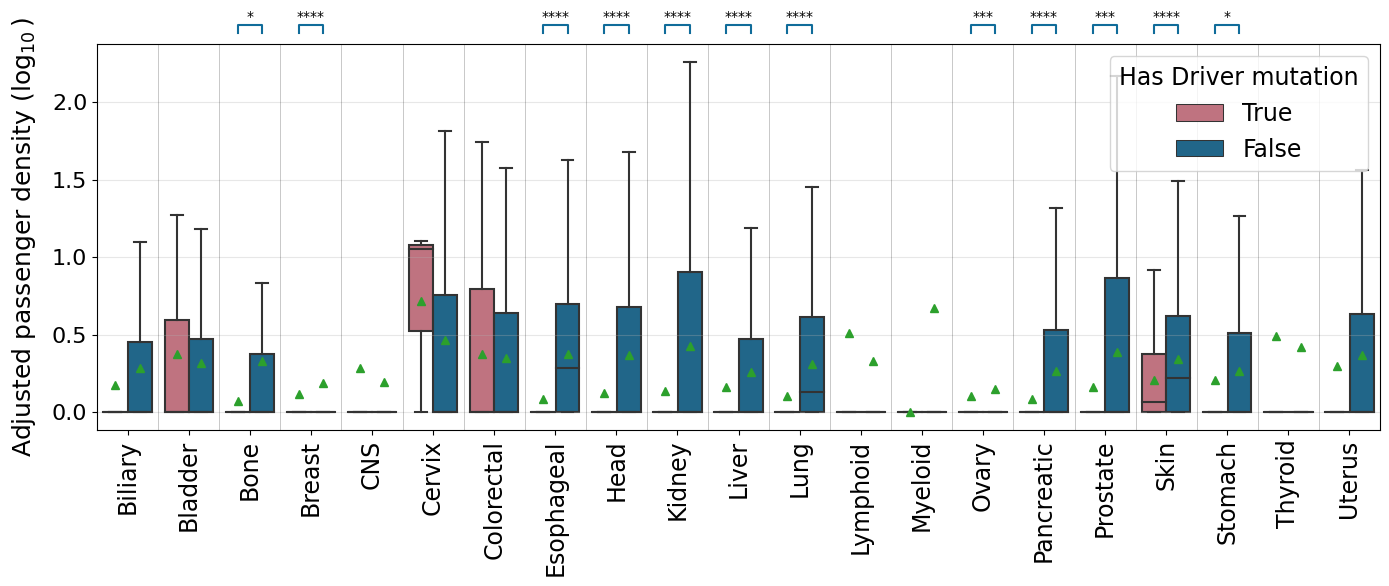

In [31]:
# distribution of passenger mutation density by cancer type
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))
cancers = passenger_density["organ"].unique().tolist()
cancers.sort()
plt.figure(figsize=(14, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="organ",
    y="passenger_density_log",
    hue="has_driver",
    data=passenger_density,
    palette=cmap,
    order=cancers,
    hue_order=[True, False],
    showmeans=True,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
    cancer_data = passenger_density[passenger_density["organ"] == cancer]
    if len(cancer_data["has_driver"].unique().tolist()) == 2:
        box_pairs.append(((cancer, True), (cancer, False)))
print(box_pairs)

annotator = Annotator(
    ax1, 
    data=passenger_density, 
    x="organ", 
    y="passenger_density_log", 
    hue="has_driver",
    pairs=box_pairs,
    order=cancers,
    hue_order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

# change x tick labels
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])

# labels with full cancer name
labels = cancers[:]
labels[6] = "Colorectal"
labels[7] = "Esophageal"
labels[12] = "Lymphoid"
labels[15] = "Pancreatic"
labels[16] = "Prostate"
labels[19] = "Thyroid"
ax1.set_xticklabels(labels, rotation=90, fontsize=17)

plt.xlabel("")
plt.ylabel(r"Adjusted passenger density ($\log_{10}$)", fontsize=18, labelpad=10)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.legend(title="Has Driver mutation", title_fontsize=17, fontsize=17, loc='upper right')
# plt.savefig("../results/passenger_density.pdf", bbox_inches='tight')

[(('Biliary-AdenoCA', True), ('Biliary-AdenoCA', False)), (('Bladder-TCC', True), ('Bladder-TCC', False)), (('Bone-Leiomyo', True), ('Bone-Leiomyo', False)), (('Bone-Osteosarc', True), ('Bone-Osteosarc', False)), (('Breast-AdenoCa', True), ('Breast-AdenoCa', False)), (('Breast-LobularCa', True), ('Breast-LobularCa', False)), (('CNS-GBM', True), ('CNS-GBM', False)), (('CNS-Medullo', True), ('CNS-Medullo', False)), (('CNS-Oligo', True), ('CNS-Oligo', False)), (('CNS-PiloAstro', True), ('CNS-PiloAstro', False)), (('Cervix-SCC', True), ('Cervix-SCC', False)), (('ColoRect-AdenoCA', True), ('ColoRect-AdenoCA', False)), (('Eso-AdenoCa', True), ('Eso-AdenoCa', False)), (('Head-SCC', True), ('Head-SCC', False)), (('Kidney-ChRCC', True), ('Kidney-ChRCC', False)), (('Kidney-RCC', True), ('Kidney-RCC', False)), (('Liver-HCC', True), ('Liver-HCC', False)), (('Lung-AdenoCA', True), ('Lung-AdenoCA', False)), (('Lung-SCC', True), ('Lung-SCC', False)), (('Lymph-BNHL', True), ('Lymph-BNHL', False)), (('

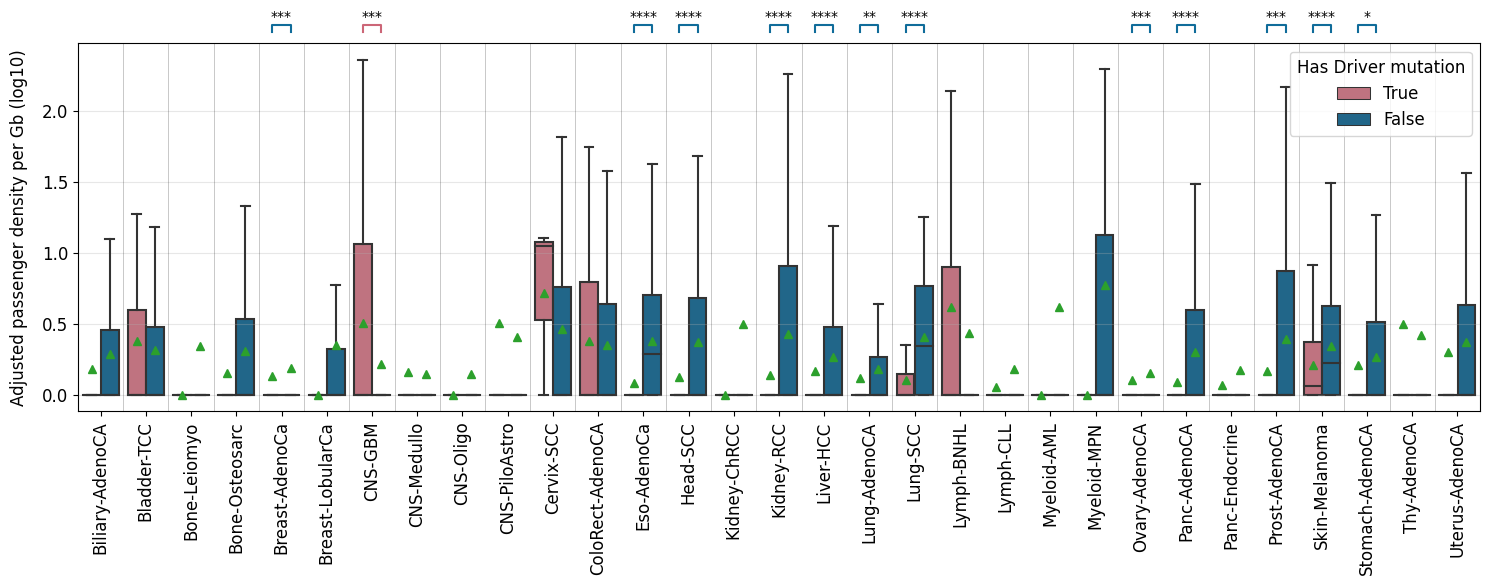

In [32]:
# distribution of passenger mutation density by cancer type
cancers = passenger_density["cancer_type"].unique().tolist()
cancers.sort()
plt.figure(figsize=(15, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="cancer_type",
    y="passenger_density_log",
    hue="has_driver",
    data=passenger_density,
    palette=cmap,
    order=cancers,
    hue_order=[True, False],
    showmeans=True,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
    cancer_data = passenger_density[passenger_density["cancer_type"] == cancer]
    if len(cancer_data["has_driver"].unique().tolist()) == 2:
        box_pairs.append(((cancer, True), (cancer, False)))
print(box_pairs)

annotator = Annotator(
    ax1, 
    data=passenger_density, 
    x="cancer_type", 
    y="passenger_density_log", 
    hue="has_driver",
    pairs=box_pairs,
    order=cancers,
    hue_order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

# change x tick labels
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])

plt.xticks(rotation=90, fontsize=12)
plt.xlabel("")
plt.ylabel("Adjusted passenger density per Gb (log10)", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.legend(title="Has Driver mutation", title_fontsize=12, fontsize=12, loc='upper right')

[(('Biliary-AdenoCA', True), ('Biliary-AdenoCA', False)), (('Bladder-TCC', True), ('Bladder-TCC', False)), (('Bone-Leiomyo', True), ('Bone-Leiomyo', False)), (('Bone-Osteosarc', True), ('Bone-Osteosarc', False)), (('Breast-AdenoCa', True), ('Breast-AdenoCa', False)), (('Breast-LobularCa', True), ('Breast-LobularCa', False)), (('CNS-GBM', True), ('CNS-GBM', False)), (('CNS-Medullo', True), ('CNS-Medullo', False)), (('CNS-Oligo', True), ('CNS-Oligo', False)), (('CNS-PiloAstro', True), ('CNS-PiloAstro', False)), (('Cervix-SCC', True), ('Cervix-SCC', False)), (('ColoRect-AdenoCA', True), ('ColoRect-AdenoCA', False)), (('Eso-AdenoCa', True), ('Eso-AdenoCa', False)), (('Head-SCC', True), ('Head-SCC', False)), (('Kidney-ChRCC', True), ('Kidney-ChRCC', False)), (('Kidney-RCC', True), ('Kidney-RCC', False)), (('Liver-HCC', True), ('Liver-HCC', False)), (('Lung-AdenoCA', True), ('Lung-AdenoCA', False)), (('Lung-SCC', True), ('Lung-SCC', False)), (('Lymph-BNHL', True), ('Lymph-BNHL', False)), (('

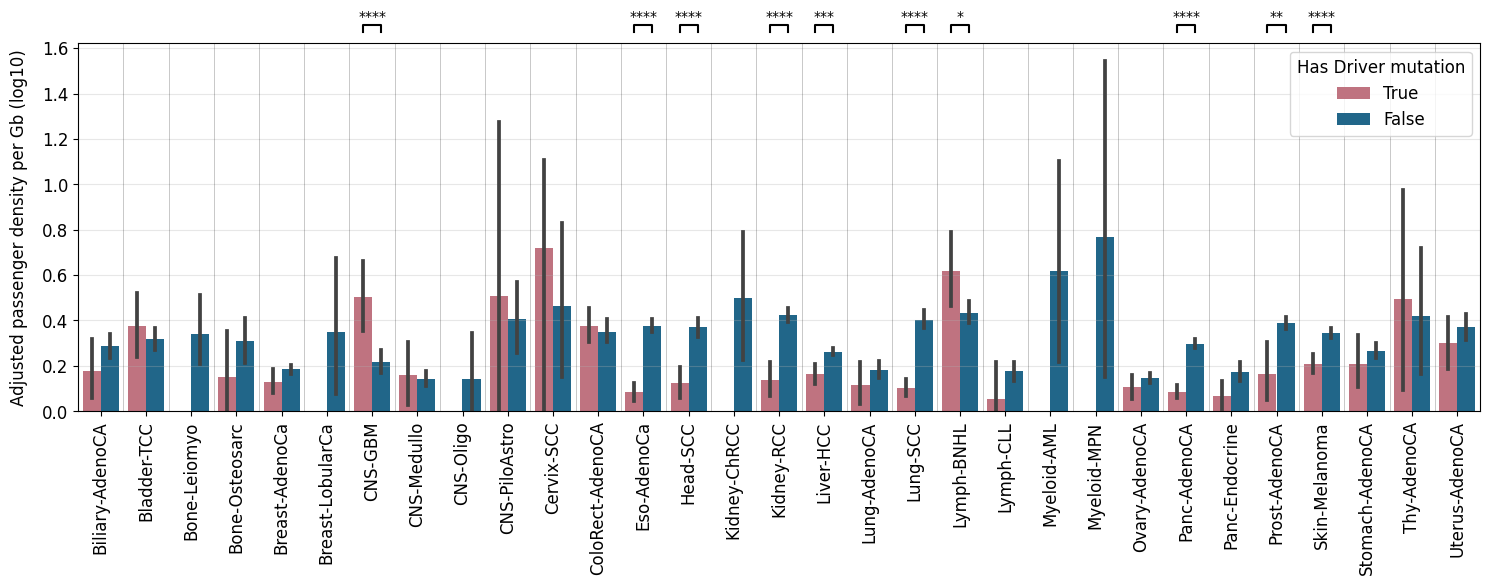

In [33]:
# distribution of passenger mutation density by cancer type
cancers = passenger_density["cancer_type"].unique().tolist()
cancers.sort()
plt.figure(figsize=(15, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.barplot(
    x="cancer_type",
    y="passenger_density_log",
    hue="has_driver",
    data=passenger_density,
    palette=cmap,
    order=cancers,
    hue_order=[True, False]
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
    cancer_data = passenger_density[passenger_density["cancer_type"] == cancer]
    if len(cancer_data["has_driver"].unique().tolist()) == 2:
        box_pairs.append(((cancer, True), (cancer, False)))
print(box_pairs)

annotator = Annotator(
    ax1, 
    data=passenger_density, 
    x="cancer_type", 
    y="passenger_density_log", 
    hue="has_driver",
    pairs=box_pairs,
    order=cancers,
    hue_order=[True, False]
)
annotator.configure(test='t-test_ind', text_format='star', loc='outside', hide_non_significant=True, color='black')
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

# change x tick labels
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])

plt.xticks(rotation=90, fontsize=12)
plt.xlabel("")
plt.ylabel("Adjusted passenger density per Gb (log10)", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.legend(title="Has Driver mutation", title_fontsize=12, fontsize=12, loc='upper right')

## Difference in observed and expected frequencies

In [34]:
upper_limit = 10
passenger_counts = passenger_density[["has_driver", "passenger_count"]].copy()
passenger_counts = passenger_counts[passenger_counts["passenger_count"] <= upper_limit]
passenger_counts.head()

,has_driver,passenger_count
0,True,0
2,True,0
3,False,1
4,False,1
5,False,2


In [35]:
# chi-square test

# all samples
print("All samples")
observed = pd.crosstab(
    passenger_counts["has_driver"],
    passenger_counts["passenger_count"],
)
print(observed)
stat, p, dof, expected = chi2_contingency(observed)
print(f"p-value: {p}, stat: {stat}")
print(expected)

All samples
passenger_count     0     1    2    3    4    5    6    7    8    9    10
has_driver                                                               
False            14912  2753  877  476  305  221  184  143  150  127  111
True              2514   334   87   32   22   12   11    8    6    3    2
p-value: 1.7497222275597425e-28, stat: 156.45002342870174
[[1.51581509e+04 2.68525260e+03 8.38543409e+02 4.41888021e+02
  2.84443667e+02 2.02676986e+02 1.69622370e+02 1.31348605e+02
  1.35697896e+02 1.13081580e+02 9.82939888e+01]
 [2.26784912e+03 4.01747402e+02 1.25456591e+02 6.61119794e+01
  4.25563332e+01 3.03230142e+01 2.53776299e+01 1.96513954e+01
  2.03021039e+01 1.69184199e+01 1.47060112e+01]]


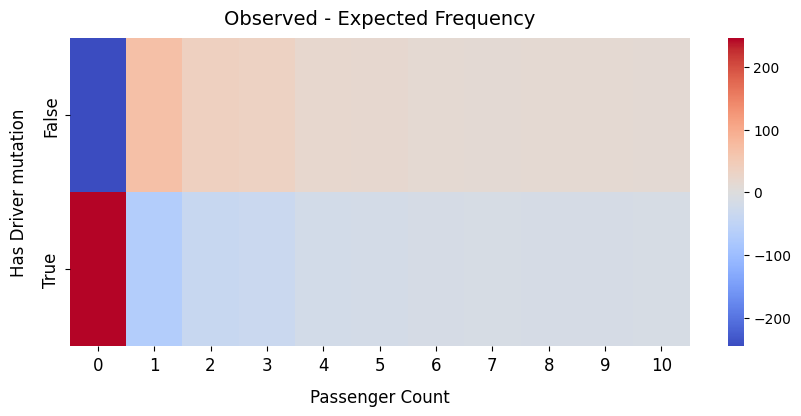

,0,1,2,3,4,5,6,7,8,9,10
False,-246.15088,67.747402,38.456591,34.111979,20.556333,18.323014,14.37763,11.651395,14.302104,13.91842,12.706011
True,246.15088,-67.747402,-38.456591,-34.111979,-20.556333,-18.323014,-14.37763,-11.651395,-14.302104,-13.91842,-12.706011


In [36]:
expected_df = pd.DataFrame(expected, columns=observed.columns, index=observed.index)
expected_df = expected_df.rename_axis(index=None, columns=None)
observed_df = pd.DataFrame(observed, columns=observed.columns, index=observed.index)
observed_df = observed_df.rename_axis(index=None, columns=None)

# get the difference between observed and expected for corresponding cells
residuals = observed_df - expected_df
plt.figure(figsize=(10, 4))
sns.heatmap(residuals, cmap='coolwarm', center=0)
plt.title("Observed - Expected Frequency", fontsize=14, pad=10)
plt.xlabel("Passenger Count", fontsize=12, labelpad=10)
plt.xticks(fontsize=12)
plt.ylabel("Has Driver mutation", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.show()
residuals

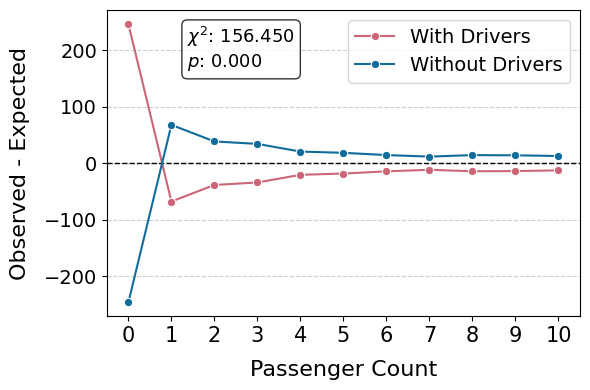

In [37]:
plt.figure(figsize=(6, 4))

# horizontal line at y=0
plt.axhline(0, color='black', lw=1, ls='--')

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[True],
	color=colors[0],
	label="With Drivers",
	marker="o",
)

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[False],
	color=colors[1],
	label="Without Drivers",
	marker="o",
)

# add p-value annotation
plt.annotate(
	rf"$\chi^2$: {stat:.3f}" + "\n" + rf"$p$: {p:.3f}", 
	xy=(0.17, 0.95), 
	xycoords='axes fraction', 
	fontsize=13, 
	ha='left', 
	va='top',
	bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.xlabel("Passenger Count", fontsize=16, labelpad=10)
plt.xticks([i for i in range(0, upper_limit + 1)], fontsize=15)
plt.ylabel("Observed - Expected", fontsize=16, labelpad=10)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()

## Frequencies for the 2 groups

In [38]:
upper_limit = 10
passenger_counts = passenger_density[["has_driver", "passenger_count"]].copy()
passenger_counts = passenger_counts[(passenger_counts["passenger_count"] <= upper_limit)]
observed_with_driver = pd.DataFrame()
observed_without_driver = pd.DataFrame()
residuals = pd.DataFrame()
for _ in range(10000):  # repeated sampling with replacement
	observed_with_driver_sampled = passenger_counts[passenger_counts["has_driver"] == True].sample(frac=1, replace=True).reset_index(drop=True)
	observed_with_driver_freq = observed_with_driver_sampled["passenger_count"].value_counts().sort_index().reset_index()
	observed_with_driver_freq = observed_with_driver_freq.rename(columns={"index": "num_passengers", "passenger_count": "frequency"})
	observed_with_driver = pd.concat([observed_with_driver, observed_with_driver_freq], ignore_index=True)
	
	observed_without_driver_sampled = passenger_counts[passenger_counts["has_driver"] == False].sample(frac=1, replace=True).reset_index(drop=True)
	observed_without_driver_freq = observed_without_driver_sampled["passenger_count"].value_counts().sort_index().reset_index()
	observed_without_driver_freq = observed_without_driver_freq.rename(columns={"index": "num_passengers", "passenger_count": "frequency"})
	observed_without_driver = pd.concat([observed_without_driver, observed_without_driver_freq], ignore_index=True)

observed_with_driver["frequency"] = np.log10(observed_with_driver["frequency"] + 1)	
observed_without_driver["frequency"] = np.log10(observed_without_driver["frequency"] + 1)

# get error bars for mean
std = observed_with_driver.groupby("num_passengers")["frequency"].std().reset_index()
std = std.rename(columns={"frequency": "std"})
observed_with_driver_mean = observed_with_driver.groupby("num_passengers")["frequency"].mean().reset_index()
observed_with_driver_mean = observed_with_driver_mean.rename(columns={"frequency": "mean"})
observed_with_driver_mean = pd.merge(observed_with_driver_mean, std, on="num_passengers", how="left")
observed_with_driver_mean["upper_limit"] = observed_with_driver_mean["mean"] + observed_with_driver_mean["std"]
observed_with_driver_mean["lower_limit"] = observed_with_driver_mean["mean"] - observed_with_driver_mean["std"]

std = observed_without_driver.groupby("num_passengers")["frequency"].std().reset_index()
std = std.rename(columns={"frequency": "std"})
observed_without_driver_mean = observed_without_driver.groupby("num_passengers")["frequency"].mean().reset_index()
observed_without_driver_mean = observed_without_driver_mean.rename(columns={"frequency": "mean"})	
observed_without_driver_mean = pd.merge(observed_without_driver_mean, std, on="num_passengers", how="left")
observed_without_driver_mean["upper_limit"] = observed_without_driver_mean["mean"] + observed_without_driver_mean["std"]
observed_without_driver_mean["lower_limit"] = observed_without_driver_mean["mean"] - observed_without_driver_mean["std"]

In [39]:
# Chi-Squared Test for Homogeneity
observed = pd.crosstab(
    observed_with_driver["num_passengers"], 
    observed_without_driver["num_passengers"]
)
stat, p, dof, expected = chi2_contingency(observed)
print(f"p-value: {p}, stat: {stat}")

p-value: 2.5335773206225305e-56, stat: 510.4538536807162


In [40]:
patients_with_drivers = passenger_counts[passenger_counts["has_driver"] == True].count().values[0]
patients_without_drivers = passenger_counts[passenger_counts["has_driver"] == False].count().values[0]

print(f"Patients with drivers: {patients_with_drivers}, Patients without drivers: {patients_without_drivers}")

Patients with drivers: 3031, Patients without drivers: 20259


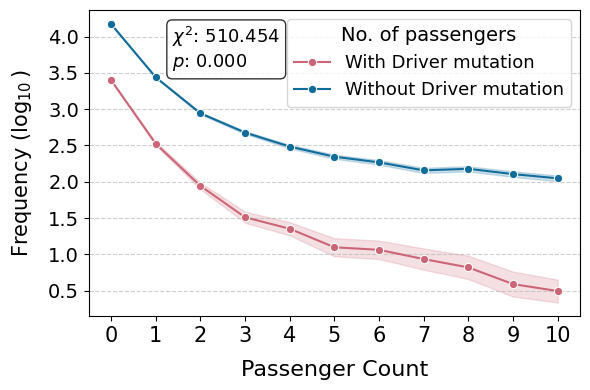

In [41]:
plt.figure(figsize=(6, 4))
sns.lineplot(
	data=observed_with_driver_mean,
	x="num_passengers",
	y="mean",
	color=colors[0],
	label="With Driver mutation",
	marker="o",
)

sns.lineplot(
	data=observed_without_driver_mean,
	x="num_passengers",
	y="mean",
	color=colors[1],
	label="Without Driver mutation",
	marker="o",
)

plt.fill_between(
	x=observed_with_driver_mean["num_passengers"],
	y1=observed_with_driver_mean["upper_limit"],
	y2=observed_with_driver_mean["lower_limit"],
	alpha=0.2,
	color=colors[0]
)

plt.fill_between(
	x=observed_without_driver_mean["num_passengers"],
	y1=observed_without_driver_mean["upper_limit"],
	y2=observed_without_driver_mean["lower_limit"],
	alpha=0.2,
	color=colors[1]
)

# add p-value annotation
plt.annotate(
	rf"$\chi^2$: {stat:.3f}" + "\n" + rf"$p$: {p:.3f}", 
	xy=(0.17, 0.95), 
	xycoords='axes fraction', 
	fontsize=13, 
	ha='left', 
	va='top',
	bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.ylabel(r"Frequency ($\log_{10}$)", fontsize=15, labelpad=10)
plt.xlabel("Passenger Count", fontsize=16, labelpad=10)
plt.xticks([i for i in range(0, upper_limit + 1)], fontsize=15)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="No. of passengers", title_fontsize=14, fontsize=13)
plt.tight_layout()